In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, datediff, col, when, avg, count
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Create a SparkSession with specific configurations
spark = SparkSession.builder \
    .appName("ETL and ELT Example with Visualizations") \
    .config("spark.master", "spark://spark-master:7077") \
    .config("spark.submit.deployMode", "client") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "3") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/12 22:17:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/12 22:17:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Step 1: Extract - Read the CSV file
df = spark.read.csv("/data/TheTrailofFire_A20YearHistoryofWildfires.csv", header=True, inferSchema=True)

In [9]:
# Force parallelization
df = df.repartition(9)

In [10]:
df = df.withColumn("initialdat", to_date("initialdat", "yyyy-MM-dd")) \
       .withColumn("finaldate", to_date("finaldate", "yyyy-MM-dd")) \
       .withColumn("days_between", 
                   when(col("days_between") == 0, 
                        datediff(col("finaldate"), col("initialdat")))
                   .otherwise(col("days_between"))) \
       .withColumn("area_km2", col("area_ha") / 100)

In [11]:
# Trigger a job to see cluster utilization
print(f"Total records: {df.count()}")

[Stage 2:=====================================================>   (16 + 1) / 17]

Total records: 22807291


In [12]:
# Step 3: Load - Write the transformed data to a Parquet file
df.write.mode("overwrite").parquet("/data/transformed_data.parquet")

In [28]:
!ls -la /data

total 2120692
drwxr-xr-x  4 jupyter jupyter        128 Mar 12 22:11 .
drwxr-xr-x  1 root    root          4096 Mar 12 21:55 ..
-rw-rw-r--  1 jupyter jupyter 2171583240 Mar 12  2024 TheTrailofFire_A20YearHistoryofWildfires.csv
drwxr-xr-x 38 jupyter jupyter       1216 Mar 12 22:11 transformed_data.parquet


# ELT Process

In [29]:
# Step 1: Extract - Read the transformed Parquet file
elt_df = spark.read.parquet("/data/transformed_data.parquet")

In [30]:
elt_df

DataFrame[_c0: int, id: int, initialdat: date, finaldate: date, area_ha: double, longitude: double, latitude: double, days_between: int, area_km2: double]

In [31]:
# Step 2: Load - Create a temporary view for SQL queries
elt_df.createOrReplaceTempView("land_data")

In [32]:
# Step 3: Transform - Perform analytical queries
# Calculate average area by latitude range
avg_area_by_lat = spark.sql("""
    SELECT 
        CASE 
            WHEN latitude >= -90 AND latitude < -60 THEN 'South Polar'
            WHEN latitude >= -60 AND latitude < -30 THEN 'South Temperate'
            WHEN latitude >= -30 AND latitude < 0 THEN 'South Tropical'
            WHEN latitude >= 0 AND latitude < 30 THEN 'North Tropical'
            WHEN latitude >= 30 AND latitude < 60 THEN 'North Temperate'
            ELSE 'North Polar'
        END AS latitude_zone,
        AVG(area_km2) AS avg_area
    FROM land_data
    GROUP BY 1
    ORDER BY 2 DESC
""")

# Count records by year
records_by_year = spark.sql("""
    SELECT 
        YEAR(initialdat) AS year,
        COUNT(*) AS record_count
    FROM land_data
    GROUP BY 1
    ORDER BY 1
""")

In [33]:
# Display results
print("Average Area by Latitude Zone:")
avg_area_by_lat.show()

Average Area by Latitude Zone:


[Stage 8:>                                                        (0 + 14) / 17]

+---------------+------------------+
|  latitude_zone|          avg_area|
+---------------+------------------+
|    North Polar| 6.933974607933607|
| South Tropical|  3.90956231509875|
| North Tropical| 3.556326113160477|
|South Temperate|3.4455967605743014|
|North Temperate|3.0706245212743117|
+---------------+------------------+



In [34]:
print("\nRecord Count by Year:")
records_by_year.show()


Record Count by Year:
+----+------------+
|year|record_count|
+----+------------+
|2002|     1070756|
|2003|     1188985|
|2004|     1202318|
|2005|     1250191|
|2006|     1113898|
|2007|     1193202|
|2008|     1193764|
|2009|     1091927|
|2010|     1108320|
|2011|     1064951|
|2012|     1072016|
|2013|     1052462|
|2014|     1045941|
|2015|     1106598|
|2016|     1083817|
|2017|     1016866|
|2018|      957667|
|2019|     1021616|
|2020|     1075550|
|2021|      934551|
+----+------------+
only showing top 20 rows



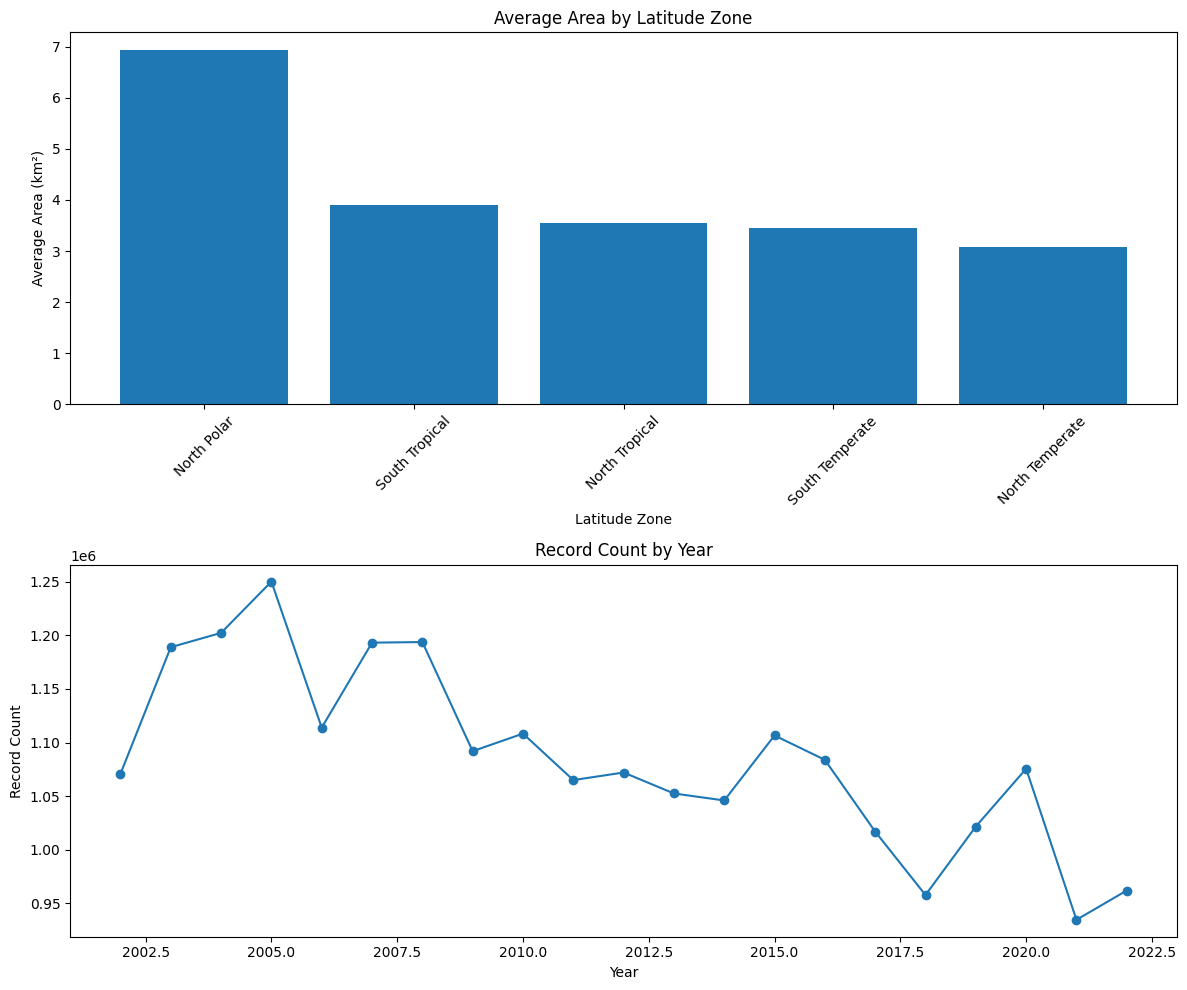

In [37]:
# Visualizations

# Convert Spark DataFrames to Pandas DataFrames for plotting
avg_area_pd = avg_area_by_lat.toPandas()
records_by_year_pd = records_by_year.toPandas()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Plot 1: Average Area by Latitude Zone
plt.subplot(2, 1, 1)
plt.bar(avg_area_pd['latitude_zone'], avg_area_pd['avg_area'])
plt.title('Average Area by Latitude Zone')
plt.xlabel('Latitude Zone')
plt.ylabel('Average Area (km²)')
plt.xticks(rotation=45)

# Plot 2: Record Count by Year
plt.subplot(2, 1, 2)
plt.plot(records_by_year_pd['year'], records_by_year_pd['record_count'], marker='o')
plt.title('Record Count by Year')
plt.xlabel('Year')
plt.ylabel('Record Count')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()